# Linear Mixed Model

In [1]:
# Uncomment the following line when running on Google Colab
# !pip install "autora"

The linear mixed model experiment has to be initialized with a specific formula and effects.

In [2]:
import numpy as np
from autora.experiment_runner.synthetic.abstract.lmm import lmm_experiment
# Formula
formula = 'rt ~ 1 + x1'
# Initialize effects:
fixed_effects = {'Intercept': 0., 'x1': 2.}

s = lmm_experiment(formula=formula, fixed_effects=fixed_effects)

Check the docstring to get information about the model

In [3]:
help(lmm_experiment)

Help on function lmm_experiment in module autora.experiment_runner.synthetic.abstract.lmm:

lmm_experiment(formula: str, fixed_effects: Optional[dict] = None, random_effects: Optional[dict] = None, X: Optional[Sequence[autora.variable.IV]] = None, random_state: Optional[int] = None, name: str = 'Linear Mixed Model Experiment')
    A linear mixed model synthetic experiments.
    
    Parameters:
        name: name of the experiment
        formula: formula of the linear mixed model (similar to lmer package in R)
        fixed_effects: dictionary describing the fixed effects (Intercept and slopes)
        random_effects: nested dictionary describing the random effects of slopes and intercept.
            These are standard deviasions in a normal distribution with a mean of zero.
        X: Independent variable descriptions. Used to add allowed values



... or use the describe function:

In [4]:
from autora.experiment_runner.synthetic.utilities import describe

print(describe(s))


    A linear mixed model synthetic experiments.

    Parameters:
        name: name of the experiment
        formula: formula of the linear mixed model (similar to lmer package in R)
        fixed_effects: dictionary describing the fixed effects (Intercept and slopes)
        random_effects: nested dictionary describing the random effects of slopes and intercept.
            These are standard deviasions in a normal distribution with a mean of zero.
        X: Independent variable descriptions. Used to add allowed values
    


The synthetic experiement `s` has properties like the name of the experiment:

In [5]:
s.name

'Linear Mixed Model Experiment'

... a valid variables description:

In [6]:
s.variables

VariableCollection(independent_variables=[IV(name='x1', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='Independent Variable', rescale=1, is_covariate=False)], dependent_variables=[DV(name='rt', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='Dependent Variable', rescale=1, is_covariate=False)], covariates=[])

... this variable description depends on the formula:

In [7]:
formula = 'probability ~ 1 + intensity'
# Initialize effects:
fixed_effects = {'Intercept': 0., 'intensity': 2.}

s = lmm_experiment(formula=formula, fixed_effects=fixed_effects)
s.variables

VariableCollection(independent_variables=[IV(name='intensity', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='Independent Variable', rescale=1, is_covariate=False)], dependent_variables=[DV(name='probability', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='Dependent Variable', rescale=1, is_covariate=False)], covariates=[])

Since we did set the variables via a formula, there is no domain:

In [8]:
s.domain()

AttributeError: 'NoneType' object has no attribute 'reshape'

We can set the variables manually in the init function:

In [9]:
from autora.variable import IV
formula = 'rt ~ 1 + x1'
# Initialize effects:
fixed_effects = {'Intercept': 0., 'x1': 2.}
independent_variables = [IV(name='x1', allowed_values=np.linspace(0, 10, 11), value_range=(0, 100))]
#
s = lmm_experiment(formula=formula, fixed_effects=fixed_effects, X=independent_variables)

... the given variable names have to match the formula:

In [10]:
from autora.variable import IV
formula_ = 'rt ~ 1 + x1'
# Initialize effects:
fixed_effects_ = {'Intercept': 0., 'x1': 2.}
independent_variables_ = [IV(name='x', allowed_values=np.linspace(0, 10, 11), value_range=(0, 100))]
#
s_ = lmm_experiment(formula=formula, fixed_effects=fixed_effects, X=independent_variables)

... now we can generate the full domain of the data

In [11]:
x = s.domain()
x

array([[ 0.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 8.],
       [ 9.],
       [10.]])

... the experiment_runner which can be called to generate experimental results:

In [12]:
experiment_data = s.run(x)
experiment_data

,x1,rt
0,0.0,0.006061
1,1.0,1.988994
2,2.0,4.007712
3,3.0,5.980667
4,4.0,7.997771
5,5.0,9.997181
6,6.0,12.018475
7,7.0,13.990661
8,8.0,16.001257
9,9.0,17.998309


... we could also run without noise:

In [22]:
s.run(x, added_noise=0)

,x1,rt
0,0.0,0.0
1,1.0,2.0
2,2.0,4.0
3,3.0,6.0
4,4.0,8.0
5,5.0,10.0
6,6.0,12.0
7,7.0,14.0
8,8.0,16.0
9,9.0,18.0


... a function to plot the ground truth (no noise):

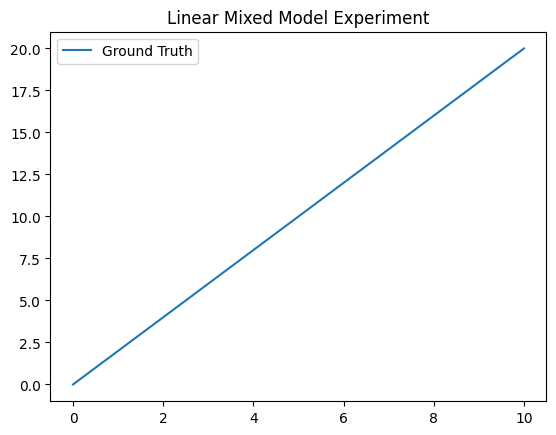

In [23]:
s.plotter()

... against a fitted model if it exists:

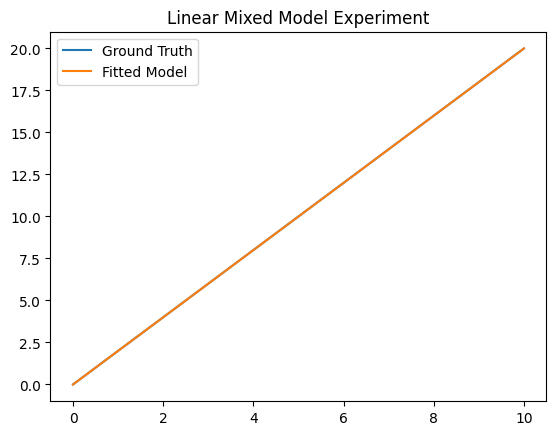

In [24]:
from sklearn.linear_model import LinearRegression
ivs = [iv.name for iv in s.variables.independent_variables]
dvs = [dv.name for dv in s.variables.dependent_variables]
X = experiment_data[ivs]
y = experiment_data[dvs]
model = LinearRegression().fit(X, y)
s.plotter(model)

We can wrap this functions to use with the state logic of AutoRA:
First, we create the state with the variables:

In [25]:
from autora.state import StandardState, on_state, experiment_runner_on_state, estimator_on_state
from autora.experimentalist.grid import grid_pool
from autora.experimentalist.random import random_sample

# We can get the variables from the runner
variables = s.variables

# With the variables, we initialize a StandardState
state = StandardState(variables)

Wrap the experimentalists in `on_state` function to use them on state:

In [26]:
# Wrap the functions to use on state
# Experimentalists:
pool_on_state = on_state(grid_pool, output=['conditions'])
sample_on_state = on_state(random_sample, output=['conditions'])

state = pool_on_state(state)
state = sample_on_state(state, num_samples=2)
print(state.conditions)

    x1
4  4.0
1  1.0


Wrap the runner with the `experiment_runner_on_state` wrapper to use it on state:

In [27]:
# Runner:
run_on_state = experiment_runner_on_state(s.run)
state = run_on_state(state)

state.experiment_data

,x1,rt
4,4.0,8.014508
1,1.0,2.019479


Wrap the regressor with the `estimator_on_state` wrapper:

In [28]:
theorist = LinearRegression()
theorist_on_state = estimator_on_state(theorist)

state = theorist_on_state(state)
# Access the last model:
model = state.models[-1]


print(f"rt = "
      f"{model.coef_[0][0]:.2f}*S0 "
      f"{model.intercept_[0]:+.2f} ")

rt = 2.00*S0 +0.02 
